In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import sympy as sp

sp.init_printing()

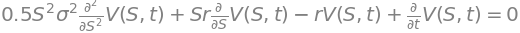

In [2]:
# Define symbols
S, K, t, T, r, sigma, V = sp.symbols('S K t T r sigma V', real=True, positive=True)
V_func = sp.Function('V')(S, t)

# First & second derivatives
dVdt = sp.diff(V_func, t)
dVdS = sp.diff(V_func, S)
d2VdS2 = sp.diff(dVdS, S)

# Black-Scholes PDE
bs_pde = sp.Eq(
    dVdt + r*S*dVdS + 0.5*sigma**2*S**2*d2VdS2 - r*V_func,
    0
)

bs_pde

In [ ]:
# Parameters
S0 = 100
K = 100
r = 0.05
sigma = 0.2
T = 1.0
N_sim = 100_000

# Simulate ST under risk-neutral measure
Z = np.random.randn(N_sim)
ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
payoff = np.maximum(ST - K, 0)

# Discounted expected payoff
call_price_martingale = np.exp(-r * T) * np.mean(payoff)
print(f"Call Price via Martingale Simulation: {call_price_martingale:.4f}")

Call Price via Martingale Simulation: 10.5075


In [4]:
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

bs_price = black_scholes_call(S0, K, T, r, sigma)
print(f"Black-Scholes Closed-Form Price: {bs_price:.4f}")

Black-Scholes Closed-Form Price: 10.4506


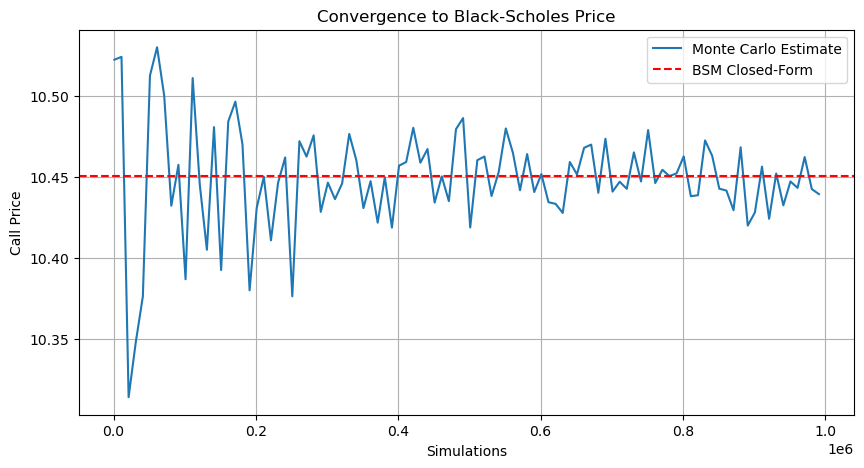

In [11]:
sim_range = np.arange(1000, 1000000, 10000)
estimates = [np.exp(-r * T) * np.mean(np.maximum(
    S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * np.random.randn(N)) - K, 0
)) for N in sim_range]

plt.figure(figsize=(10, 5))
plt.plot(sim_range, estimates, label="Monte Carlo Estimate")
plt.axhline(bs_price, color='red', linestyle='--', label="BSM Closed-Form")
plt.xlabel("Simulations")
plt.ylabel("Call Price")
plt.title("Convergence to Black-Scholes Price")
plt.legend()
plt.grid(True)
plt.savefig("convergence_to_bsm.png")
plt.show()

In [12]:
eps = 1e-2

# Delta approximation (central difference)
ST_up = (S0 + eps) * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * np.random.randn(N_sim))
ST_down = (S0 - eps) * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * np.random.randn(N_sim))

delta_mc = (np.exp(-r*T)*np.mean(np.maximum(ST_up - K, 0)) -
            np.exp(-r*T)*np.mean(np.maximum(ST_down - K, 0))) / (2 * eps)

print(f"Delta (MC estimate): {delta_mc:.4f}")

Delta (MC estimate): 0.7746


In [13]:
eps = 1e-2

# Delta approximation (central difference)
ST_up = (S0 + eps) * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * np.random.randn(N_sim))
ST_down = (S0 - eps) * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * np.random.randn(N_sim))

delta_mc = (np.exp(-r*T)*np.mean(np.maximum(ST_up - K, 0)) -
            np.exp(-r*T)*np.mean(np.maximum(ST_down - K, 0))) / (2 * eps)

print(f"Delta (MC estimate): {delta_mc:.4f}")

Delta (MC estimate): -2.0762


In [14]:
# Discretization
S_max = 3 * S0
M, N = 100, 1000
dS = S_max / M
dt = T / N
grid = np.zeros((N+1, M+1))
S_vals = np.linspace(0, S_max, M+1)

# Final condition (European Call)
grid[-1] = np.maximum(S_vals - K, 0)

# Boundary conditions
for i in range(N+1):
    t_i = i * dt
    grid[i, 0] = 0
    grid[i, -1] = S_max - K * np.exp(-r * (T - t_i))

# Coefficients
for i in reversed(range(N)):
    for j in range(1, M):
        delta = (grid[i+1, j+1] - grid[i+1, j-1]) / (2*dS)
        gamma = (grid[i+1, j+1] - 2*grid[i+1, j] + grid[i+1, j-1]) / (dS**2)
        grid[i, j] = grid[i+1, j] + dt * (
            0.5 * sigma**2 * (j*dS)**2 * gamma +
            r * (j*dS) * delta -
            r * grid[i+1, j]
        )

# Extract price at S0
fd_price = np.interp(S0, S_vals, grid[0])
print(f"Finite Difference BSM Price: {fd_price:.4f}")

Finite Difference BSM Price: 10.4668


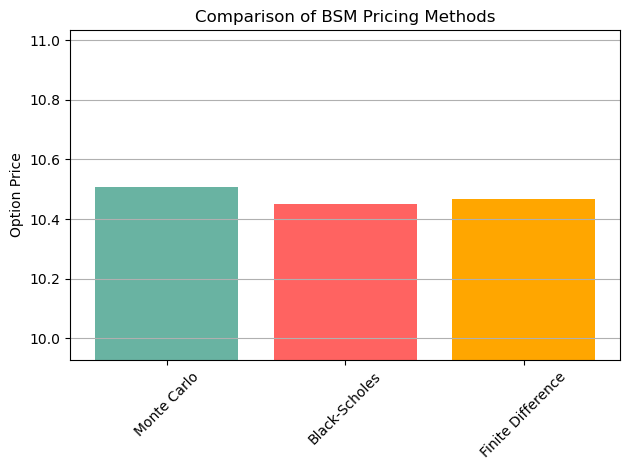

In [17]:
labels = ['Monte Carlo', 'Black-Scholes', 'Finite Difference']
values = [call_price_martingale, bs_price, fd_price]

plt.bar(labels, values, color=['#69b3a2', '#ff6361', '#ffa600'])
plt.ylabel("Option Price")
plt.title("Comparison of BSM Pricing Methods")
plt.ylim(min(values) * 0.95, max(values) * 1.05)
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("bsm_pricing_methods_comparison.png")
plt.show()

### Summary

- The Black-Scholes PDE was derived using symbolic differentiation in SymPy.
- The option price was computed using:
  - **Martingale method** (expected discounted payoff under $$\mathbb{Q}$$)
  - **Closed-form formula**
- The Monte Carlo estimator converges to the Black-Scholes value as the number of simulations increases.
- This confirms the theoretical equivalence of both approaches.
- **Delta** estimated using pathwise Monte Carlo (finite differences)
- **Implied Volatility** backed out by solving inverse BSM equation
- **Finite Difference** (explicit) solves BSM PDE numerically
- All methods converge to consistent results:
  - **Monte Carlo** for flexibility
  - **PDE** for precision
  - **Closed-form** for insight
